In [15]:
import kagglehub
import pandas as pd
import numpy as np
import pygsp as pg
import matplotlib.pyplot as plt
import re

from scipy import sparse
from scipy.sparse.csgraph import connected_components
from sklearn.metrics.pairwise import haversine_distances

In [2]:
data_path = kagglehub.dataset_download("berkeleyearth/climate-change-earth-surface-temperature-data")

100%|████████████████████████████████████████████████████████████████████| 84.7M/84.7M [00:03<00:00, 23.4MB/s]

Extracting files...


In [5]:
df = pd.read_csv(data_path+'/GlobalLandTemperaturesByCity.csv')

# Convert date to datetime and filter to recent period for simplicity
df['dt'] = pd.to_datetime(df['dt'])
df = df[(df['dt'] >= '2000-01-01') & (df['dt'] <= '2013-12-31')]

# Drop rows with missing temperatures
df = df.dropna(subset=['AverageTemperature'])

In [51]:
# Create a representative sample of cities
# Group by city and country, and take mean temperature for each location
city_avg = df.groupby(['City', 'Country', 'Latitude', 'Longitude'])['AverageTemperature'].mean().reset_index()

# For demonstration, use top 200 cities by temperate
#cities = city_avg.sort_values('AverageTemperature', ascending=False).head(200)

cities = city_avg.sample(n=200,random_state=42)

In [52]:
# Create graph structure based on geographical proximity
# Convert lat/long strings to numeric values
def extract_lat_lon(coord_str):
    """Extract numeric value and direction from coordinate string"""
    # Extract the numeric part and the direction (N/S/E/W)
    match = re.match(r'([\d.]+)([NSEW])', coord_str)
    if not match:
        return np.nan
    value, direction = match.groups()
    value = float(value)
    # Make southern and western coordinates negative
    if direction in ['S', 'W']:
        value = -value
    return value

# Apply the extraction function
cities['lat_numeric'] = cities['Latitude'].apply(extract_lat_lon)
cities['lon_numeric'] = cities['Longitude'].apply(extract_lat_lon)
cities['lat_numeric'] = cities.apply(lambda x: -x['lat_numeric'] if 'S' in x['Latitude'] else x['lat_numeric'], axis=1)
cities['lon_numeric'] = cities.apply(lambda x: -x['lon_numeric'] if 'W' in x['Longitude'] else x['lon_numeric'], axis=1)

# Create a coordinates array (in radians for haversine)
coords = np.radians(cities[['lat_numeric', 'lon_numeric']].values)

# Calculate the distance matrix using Haversine formula (earth radius = 6371 km)
dist_matrix = haversine_distances(coords, coords) * 6371

# Create adjacency matrix by connecting cities within 1000 km
threshold_distance = 1000  # km
adjacency_matrix = (dist_matrix <= threshold_distance).astype(int)
np.fill_diagonal(adjacency_matrix, 0)  # Remove self-loops

In [53]:
# Check connectivity and ensure the graph is connected
# Find connected components
n_components, labels = connected_components(sparse.csr_matrix(adjacency_matrix))

print(f"Initial graph has {n_components} connected components")

# If more than one component, we need to connect them
if n_components > 1:
    # Approach 1: Increase the distance threshold until connected
    threshold = threshold_distance
    max_threshold = 10000  # km, maximum distance we'll consider
    
    while n_components > 1 and threshold < max_threshold:
        threshold += 500
        adjacency_matrix = (dist_matrix <= threshold).astype(float)
        np.fill_diagonal(adjacency_matrix, 0)
        n_components, labels = connected_components(sparse.csr_matrix(adjacency_matrix))
        print(f"With threshold {threshold}km: {n_components} components")

Initial graph has 8 connected components
With threshold 1500km: 3 components
With threshold 2000km: 2 components
With threshold 2500km: 2 components
With threshold 3000km: 1 components


In [54]:
# Create graph
# Create position dictionary for visualization
positions = cities[['lon_numeric', 'lat_numeric']].values
city_names = [f"{city}, {country}" for city, country in zip(cities['City'], cities['Country'])]

# Create PyGSP graph
G = pg.graphs.Graph(adjacency_matrix)
G.set_coordinates(positions)

# Set node signal (temperature)
signal = cities['AverageTemperature'].values

In [55]:
# Noisy signal
rs = np.random.RandomState(42)  # Reproducible result
noisy_signal = signal + rs.uniform(-1, 1, size=G.N)

In [56]:
# low-pass filtering 
# Normalized adjacency matrix for better numerics
D = np.diag(np.sum(adjacency_matrix, axis=1))
D_inv = np.diag(1 / np.maximum(np.diag(D), 1e-10))
A_norm = D_inv @ adjacency_matrix 

# Parameter alpha controls smoothing strength (between 0 and 1)
alpha = 0.5
I = np.eye(len(A_norm))

# Low-pass filter in node space: x_smooth = alpha * x + (1-alpha) * A_norm * x
filter_node = alpha * I + (1 - alpha) * A_norm

filtered_noisy_signal = filter_node @ noisy_signal

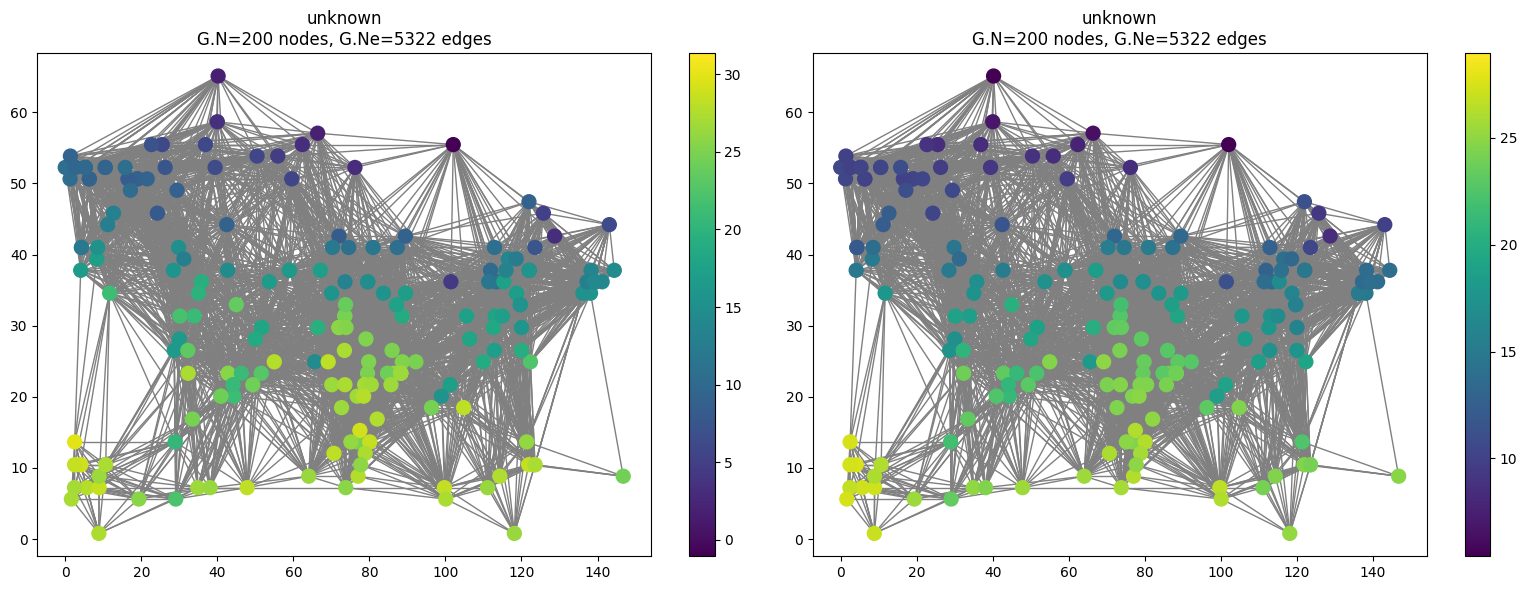

In [57]:
plt.figure(figsize=(16, 6))
ax1 = plt.subplot(121)
G.plot_signal(noisy_signal, ax=ax1, colorbar=True)

ax2 = plt.subplot(122)
G.plot_signal(filtered_noisy_signal, ax=ax2, colorbar=True)

plt.tight_layout()
plt.show()

In [58]:
city_names

['Tyumen, Russia',
 'Belford Roxo, Brazil',
 'Salta, Argentina',
 'Cherkessk, Russia',
 'Ekibastuz, Kazakhstan',
 'Hachioji, Japan',
 'Vilnius, Lithuania',
 'Midrand, South Africa',
 'Hulan, China',
 'Istanbul, Turkey',
 'Ebina, Japan',
 'Ijero, Nigeria',
 'Novotroitsk, Russia',
 'Yelahanka, India',
 'Avadi, India',
 'Velluru, India',
 'Denizli, Turkey',
 'Joetsu, Japan',
 'Hafizabad, Pakistan',
 'Kaunas, Lithuania',
 'Burewala, Pakistan',
 'Maastricht, Netherlands',
 'Jaranwala, Pakistan',
 'San Luis Potosí, Mexico',
 'Severodvinsk, Russia',
 'Alexandria, Egypt',
 'Moradabad, India',
 'Kulti, India',
 'Concepcion, Chile',
 'Chhatarpur, India',
 'Melbourne, Australia',
 'Hsichih, Taiwan',
 'Multan, Pakistan',
 'Silchar, India',
 'Yingzhong, China',
 'Hat Yai, Thailand',
 'Liuzhou, China',
 'Damoh, India',
 'Hino, Japan',
 'Kasugai, Japan',
 'Narita, Japan',
 'Anyang, China',
 'Cotonou, Benin',
 'Xiantao, China',
 'Gondal, India',
 'Rawalpindi, Pakistan',
 'Adana, Turkey',
 'Niamey, Nig